In [1]:
import sys
sys.path.insert(0, "/home/thibault/dev/chrysostylom/")

import pandas as pd
from matplotlib import pyplot as plt

from freestyl.stats.moisl import moisl
from freestyl.stats.frequencies import df_relative_frequencies, relative_frequencies, z_transform, normalizations
from freestyl.unsupervised.dendogram import ManhattanClassifier
from freestyl.dataset.dataframe_wrapper import DataframeWrapper

## Configuration

In [2]:
K = 22 - 6 # Number of PC - those removed
MOISL = 1.91
FEATURES = 40

## Data retrieval

In [3]:
df = pd.read_csv("function-words.csv")
df.head()
df = df[df.author != "PC7"]
df = df[df.author != "PC1"]
df = df[df.author != "PC4"]
df = df[df.author != "PC10"] # Sermo 1 and 2
df = df[df.author != "PC21"] # Sermo 2 and 3
df = df[df.author != "PC6"] # Sermo 1-3
df.set_index(["author", "title", "file", "tokens"], inplace=True)
# Dropping non existing feature
df = df.loc[:, df.sum(axis=0) > 0]
df.reset_index(inplace=True)

## Create data

In [4]:
DFW = DataframeWrapper(df, label=("author", "title"), target="title", x_ignore=("file", "tokens"))
classifier = ManhattanClassifier(DFW)

## Build the classifier

In [5]:
classifier.build(apply_moisl=MOISL)

In [6]:
print(DFW.normalized.xs.shape)
DFW.normalized.xs.head(1)

(42, 189)


,τὴν,καὶ,ἐν,ταῖς,τῶν,τὸ,τοῦ,τοῖς,εἰσιν,οἱ,...,σὴ,ἄρτι,ἕξει,ἔχετε,τόνδε,γεγένηται,σοὺς,λίαν,κἀκείνου,ποίᾳ
0,-0.102633,-0.01986,0.126284,-0.007916,-0.059501,-0.001654,0.026297,-0.055026,0.029721,-0.068408,...,-0.010678,-0.012579,-0.009141,-0.013019,-0.010578,-0.013429,-0.010775,-0.009415,-0.011498,-0.010056


In [2]:
# Compute DFW distances ?

## Retrieve clusters (compute CAH)

In [7]:
clusters = classifier.get_clusters(k=K)
#clusters.to_csv("results/unsupervised/fwords-clusters.csv")
clusters.sort_values("Class")

,author,title,Class
38,PC14,DeEleemosyna,1
19,PC13,ContraIudaeosGentilesHaereticos,1
7,PC9,InIlludPatterSiPossibile,10
4,PC3,InIlludCollegerunt,10
0,PC20,InIlludCredidiPropterQuodLocutusSum,10
1,PC13,InVenerabilemCrucem,10
16,PC20b,DeNonJudicandoProximo,10
18,PC5,InSanctaVirginem,11
3,PC8,DePatientiaSermo1,11
39,PC12,SermoInPsalmum11,12


## Plot the CAH dendogram

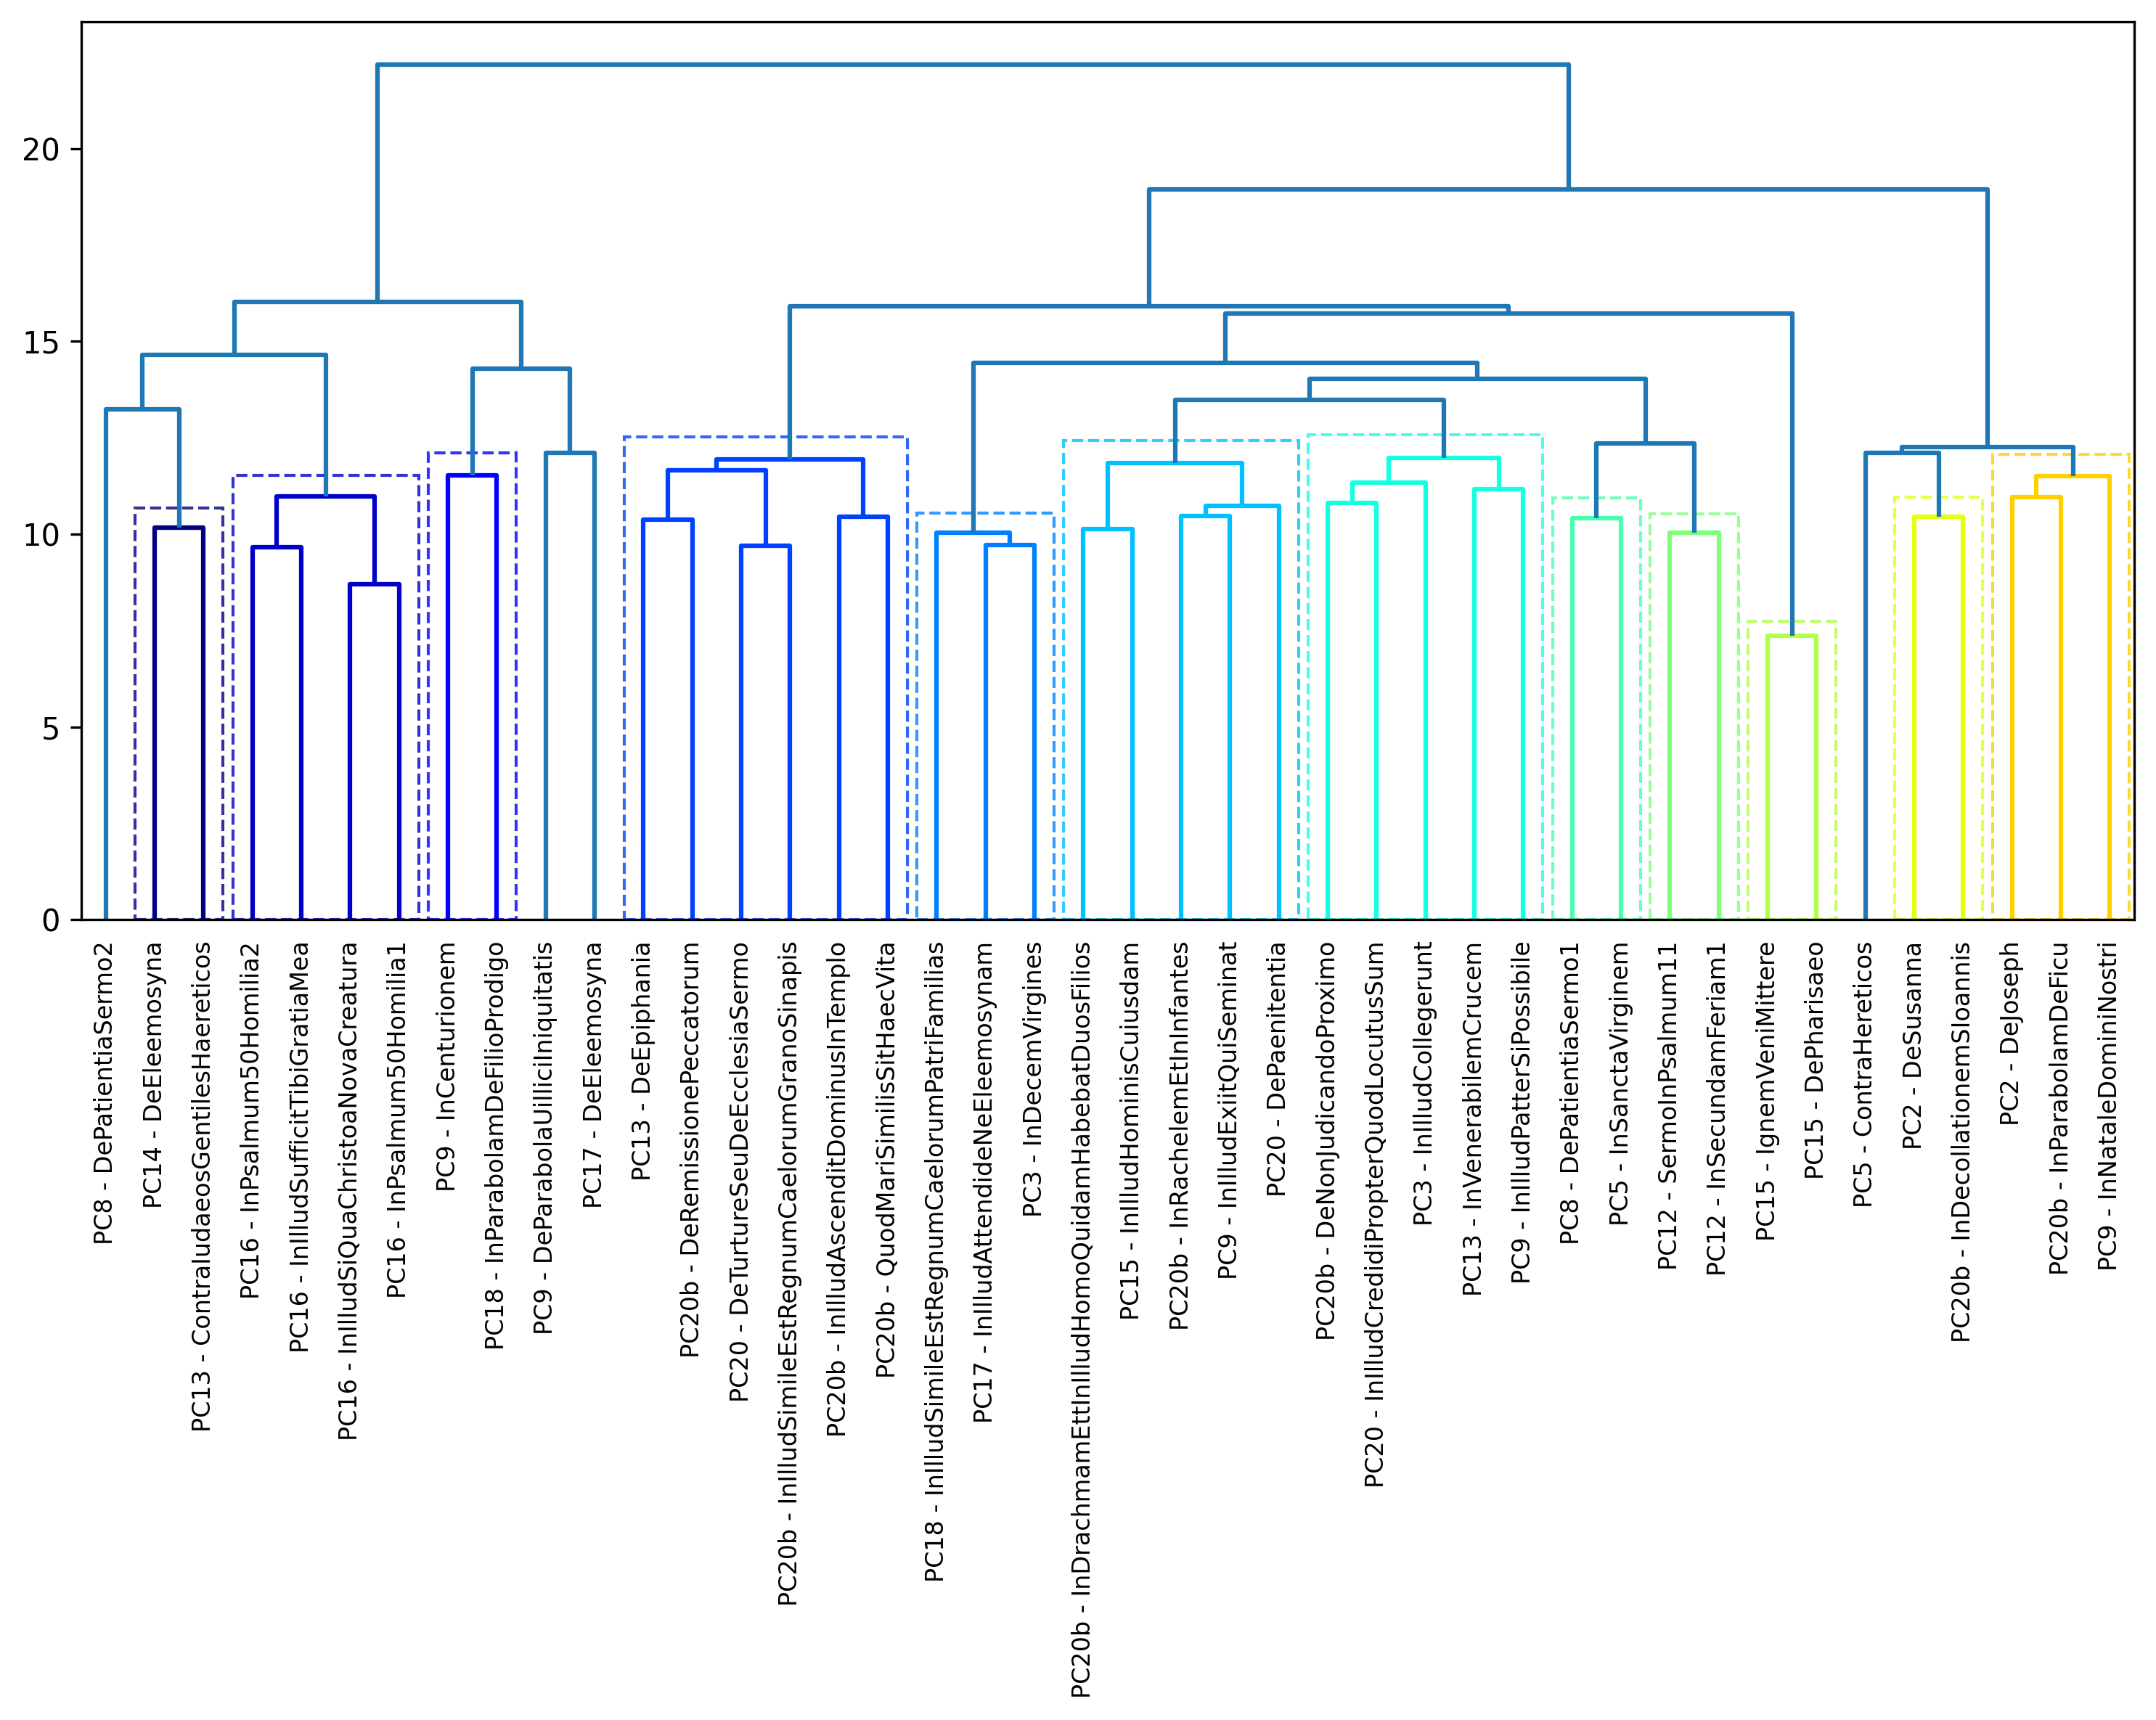

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8), dpi=300)

fig.patch.set_facecolor('white')
### CAH has been moved out of dendo()
### TODO:
###   Probably separate dendo plotting and dendo acquisition ?
###   Figure out where does ETA2 and other goes
ax, dendogram_scipy_dict = classifier.plot_dendogram(ax=ax, k=K)
        
plt.xticks(rotation = 90)
plt.tight_layout()
plt.savefig("fwords-unsupervised.jpg")

## Analysis notes:

- PC16 is always grouped, despite having two homelias on the same subject (In Ps. 50, Hom.) 
- PC12 is indeed connected, but it could be due to its source (different OCR from the rest)
- PC15 has two texts that hold up well: De Phariseo & Ignem Veni Mittere.
- **Not true: bad reading** PC2 holds well (2/2) but joins a PC20b text (In Decollationem S. Ioannis)
- There is a 20(1)/20b(4) cluster (Quod Mari Similis; In Illud Ascendit; In Illus Similes Est Regnum; De Turture (20); De remissione) that is connected to a 13 text (De Epiphania)

Other classes do not hold up

## Feature / Class relationship: ETA2

In [9]:
eta2 = classifier.get_features_eta2(top=FEATURES)
eta2

,Eta 2,p-value
Class,,
ἣ,0.969714,6.951463e-16
ἔξωθεν,0.931491,2.217234e-11
οὐχὶ,0.838920,7.978748e-07
ἦν,0.795985,1.263159e-05
ἔχῃ,0.788328,1.926712e-05
πάντα,0.770278,4.874153e-05
τὰς,0.741657,1.798489e-04
οὐ,0.734487,2.426361e-04
τί,0.734127,2.462460e-04


In [10]:
# Align the most important features with our classes and documents
class_aligned_eta2, eta2_top_features = classifier.eta2_to_classes(eta2)
class_aligned_eta2

,ἣ,ἔξωθεν,οὐχὶ,ἦν,ἔχῃ,πάντα,τὰς,οὐ,τί,ἄλλοι,...,οὗ,ταῖς,πᾶσα,οὐδὲν,αὐτὰς,αὐτῇ,εἰμὶ,ἀλλὰ,πρὸ,Class
0,-0.015348,-0.019754,-0.021965,0.007366,-0.016077,-0.033898,-0.013234,0.036531,0.035502,-0.020009,...,0.000021,-0.007916,-0.028957,-0.038427,0.040605,-0.001182,-0.025836,-0.015098,0.008650,10
1,-0.016683,-0.021472,-0.023876,0.030154,-0.017476,0.029974,0.024177,-0.021108,0.005980,-0.021749,...,-0.005304,-0.014626,-0.031476,-0.041770,-0.022615,0.030000,-0.028083,0.036836,0.002800,10
2,-0.000553,-0.007621,0.012873,0.134274,-0.028233,0.058620,-0.116172,0.136378,0.266287,0.138827,...,-0.042864,-0.062397,-0.050849,0.004952,-0.036535,-0.024608,0.017826,0.228570,-0.011026,3
3,-0.017198,-0.022135,-0.024613,-0.039370,-0.018016,0.087034,-0.030016,0.016292,0.009149,0.018663,...,-0.000139,-0.043893,0.054674,0.002556,-0.023314,-0.023386,-0.028951,-0.001820,0.238703,11
4,-0.017166,-0.022093,-0.024566,-0.000874,-0.017981,-0.016742,-0.077837,-0.009716,0.131548,-0.022379,...,-0.041153,-0.014443,-0.032386,-0.042978,-0.023269,-0.045189,-0.028896,0.053754,-0.041364,10
5,-0.014537,-0.018710,-0.020804,-0.025485,-0.015228,-0.055702,0.048975,-0.007133,-0.018088,-0.018951,...,-0.034850,0.031102,-0.027426,-0.036396,-0.019706,-0.038268,-0.024470,-0.002133,-0.035029,9
6,-0.028460,-0.036630,-0.040731,0.120205,-0.029813,-0.109055,-0.016347,-0.149607,-0.099324,-0.037103,...,-0.068231,0.274670,0.048143,-0.071257,-0.038580,-0.074923,-0.047909,-0.046572,-0.068581,16
7,-0.019198,-0.024709,-0.027475,-0.060027,-0.020111,0.087034,-0.067350,-0.069863,0.008750,-0.025029,...,0.021784,-0.042797,0.011701,-0.048067,-0.026025,-0.050540,-0.032317,-0.084590,-0.046262,10
8,-0.020993,-0.027019,-0.030044,-0.082717,-0.021991,-0.019346,0.133592,-0.141430,-0.055092,-0.027368,...,-0.050328,0.136373,-0.039607,0.047664,-0.028457,-0.055264,-0.035338,-0.066399,0.061326,9
9,-0.016864,-0.021705,-0.024134,-0.047885,-0.017665,-0.037354,0.086949,0.015975,-0.000886,-0.021985,...,-0.040429,0.013897,-0.031817,-0.042222,-0.022860,-0.044394,-0.028388,-0.016948,0.109198,8


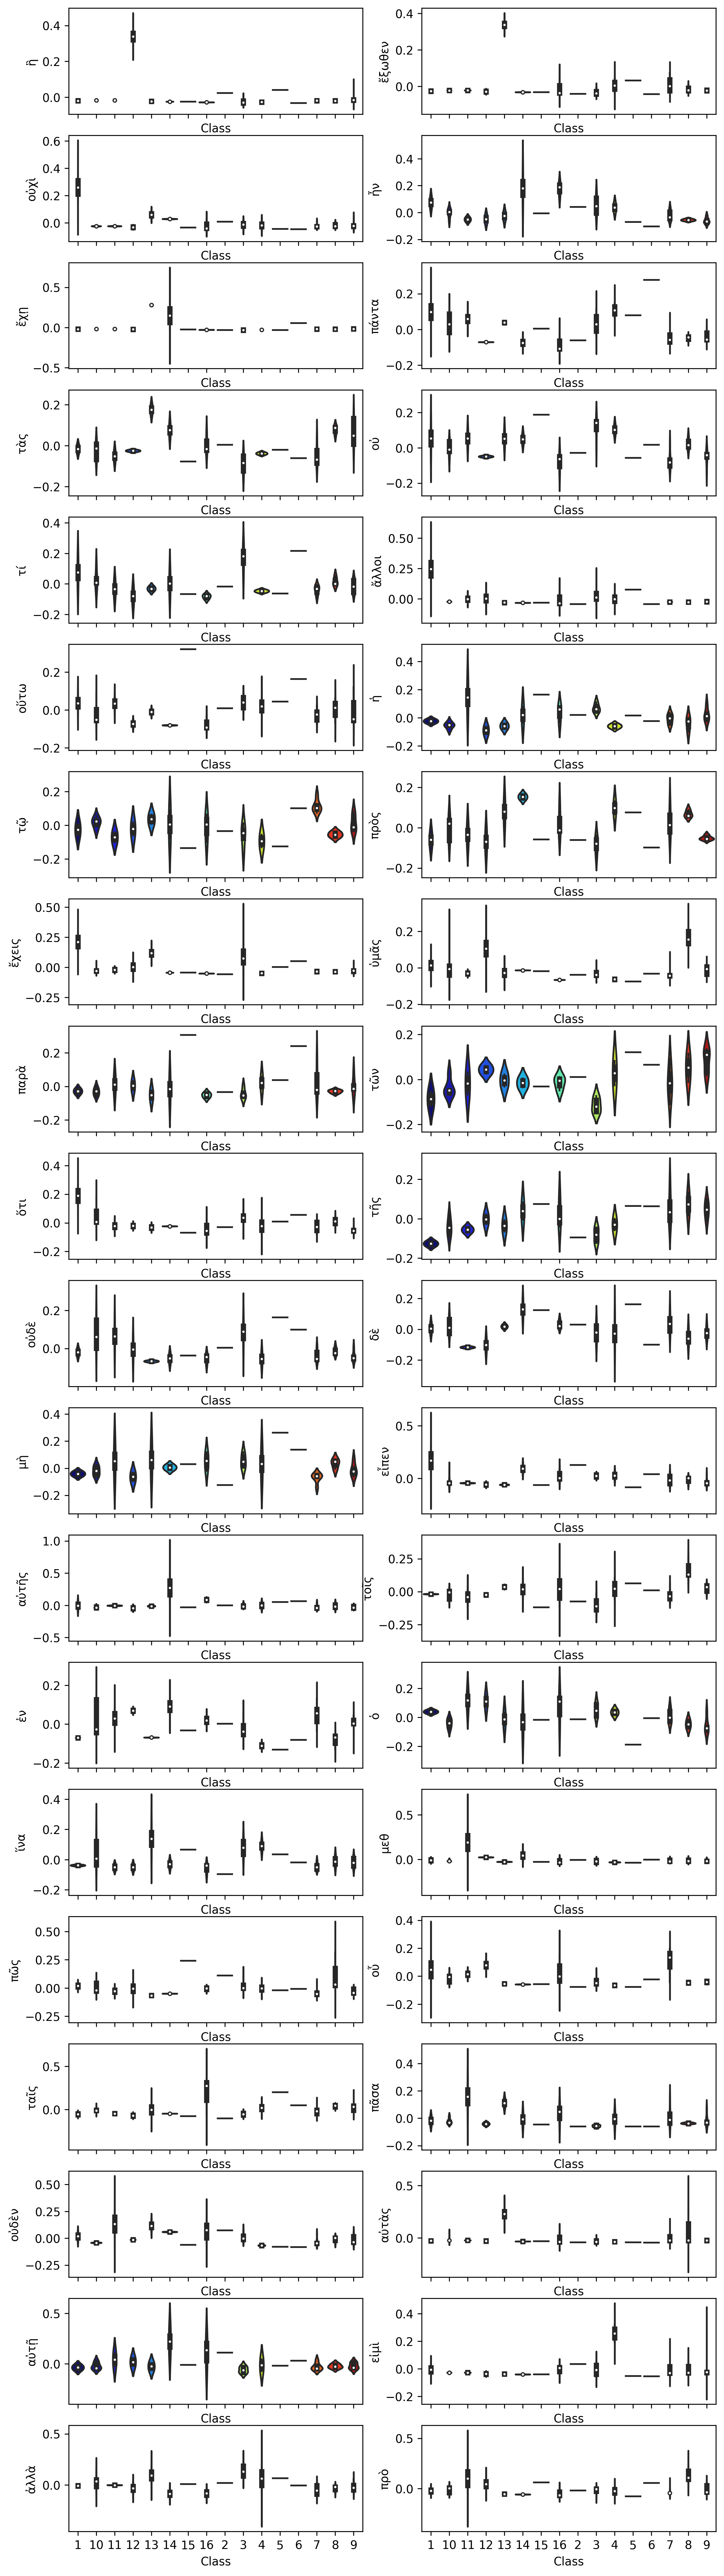

In [11]:
## Plot the distribution
fig, axes = classifier.plot_eta_2(class_aligned_eta2, eta2_top_features, fig_kwargs=dict(figsize=(10, 40), dpi=300))

plt.savefig("fwords-features.jpg")